## Getting Started: Environment Setup and Data Acquisition

Hey there! This notebook is my deep dive into understanding random forests, using the famous Titanic dataset as my playground. It his inspired by the famous https://www.kaggle.com/code/jhoward/how-random-forests-really-work from Jeremy Howard. Starting from there i tried to experiment a bit more. First things first, I set up the environment by importing key libraries and tweaking NumPy’s print options for cleaner output—trust me, it makes a difference when you’re staring at wide datasets all day.

Then, I grab the Titanic dataset via the Kaggle API. It’s a classic choice for binary classification: predicting whether a passenger survived based on features like age, sex, and class. This dataset is perfect for exploring how random forests can tease out patterns from messy, real-world data.

In [1]:
import numpy as np
import kaggle
from pathlib import Path
np.set_printoptions(linewidth=130)

In [3]:
import zipfile,kaggle

path = Path('titanic')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## Loading the Data

With the dataset downloaded, I load the training and test sets into pandas DataFrames. The training set includes the ‘Survived’ column—our target variable—while the test set doesn’t, since that’s what we’ll predict later. A quick peek with `head()` helps me get a feel for the data’s structure and spot any obvious quirks right away.

In [4]:
import pandas as pd

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing, Part 1: Handling Missing Values

Real-world data is rarely perfect, so preprocessing is where the magic starts. I calculate the modes (most frequent values) for each column to fill in missing categorical data later, it’s a simple yet effective strategy. Next, I compute medians for ‘Fare’ and ‘Age’ based on passenger class and sex combinations. This group-specific approach should be better than just overall medians for these fields because it respects the data’s natural variations, reducing imputation bias.

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
# Compute statistics from training set
modes = df.mode().iloc[0]
fare_medians = df.groupby('Pclass')['Fare'].median()
age_medians = df.groupby(['Pclass', 'Sex'])['Age'].median()

## Preprocessing, Part 2: Feature Engineering and Transformation

Here’s where I roll up my sleeves. The `proc_data` function does the heavy lifting:

- **Feature Engineering:** I create ‘CabinKnown’ to flag if a cabin is recorded (hinting at status or location), extract ‘Title’ from names (like ‘Mr.’ or ‘Mrs.’) for social cues, and compute ‘FamilySize’ and ‘IsAlone’ to capture travel dynamics.
- **Imputation:** Missing ‘Fare’ and ‘Age’ get filled with those group-specific medians, and everything else uses the modes.
- **Transformation:** A log transformation on ‘Fare’ (as ‘LogFare’) tames its skewness, fare prices can get wild, and this helps the model see patterns more clearly.
- **Categorical Types:** I convert features like ‘Sex’ and ‘Pclass’ to categorical types, which decision trees love because it simplifies splitting.

After that, I organize features into categorical and continuous lists, with ‘Survived’ as the target. This setup keeps things tidy for modeling.

In [7]:
# Define enhanced processing function
def proc_data(df):
    # Create new features
    df['CabinKnown'] = df['Cabin'].notna().astype(int)
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Fill missing values
    df['Fare'] = df['Fare'].fillna(df['Pclass'].map(fare_medians))
    df['Age'] = df['Age'].fillna(df.apply(
        lambda row: age_medians[row['Pclass'], row['Sex']] if pd.isna(row['Age']) else row['Age'], axis=1))
    df.fillna(modes, inplace=True)
    
    # Transformations
    df['LogFare'] = np.log1p(df['Fare'])
    
    # Convert to categorical
    df['Sex'] = pd.Categorical(df['Sex'])
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['Title'] = pd.Categorical(df['Title'])
    df['Pclass'] = pd.Categorical(df['Pclass'])
    df['IsAlone'] = pd.Categorical(df['IsAlone'])

proc_data(df)
proc_data(tst_df)

In [8]:
cats = ['Sex', 'Embarked', 'Title', 'Pclass', 'IsAlone']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'FamilySize', 'CabinKnown']
dep = 'Survived'

# Inspect the result
print(df[cats + conts + [dep]].head())

      Sex Embarked Title Pclass IsAlone   Age  SibSp  Parch   LogFare  \
0    male        S    Mr      3       0  22.0      1      0  2.110213   
1  female        C   Mrs      1       0  38.0      1      0  4.280593   
2  female        S  Miss      3       1  26.0      0      0  2.188856   
3  female        S   Mrs      1       0  35.0      1      0  3.990834   
4    male        S    Mr      3       1  35.0      0      0  2.202765   

   FamilySize  CabinKnown  Survived  
0           2           0         0  
1           2           1         1  
2           1           0         1  
3           2           1         1  
4           1           0         0  


## Sneak Peek with EDA

Before jumping into modeling, I like to explore the data visually. Using seaborn, I plot survival rates by sex and a count of passengers by sex. The bar plot screams that females had a much higher survival rate, think ‘women and children first’, while the count plot shows more males onboard. This quick EDA flags ‘Sex’ as a feature to watch.

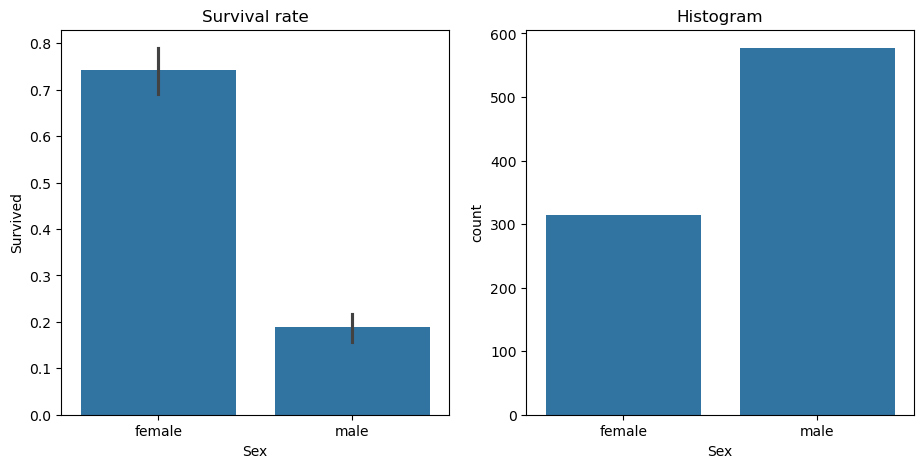

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

## Preparing for Modeling

Time to split the data into training (80%) and validation (20%) sets, setting a random seed for reproducibility. I convert categorical variables to numerical codes since decision trees need numbers, not strings. Then, I define a helper function `xs_y` to separate features from the target variable, keeping everything aligned for training.

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.2)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

trn_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsAlone,LogFare
331,332,0,0,"Partner, Mr. Austen",1,45.5,0,0,113043,28.5000,C124,2,1,12,1,1,3.384390
733,734,0,1,"Berriman, Mr. William John",1,23.0,0,0,28425,13.0000,B96 B98,2,0,12,1,1,2.639057
382,383,0,2,"Tikkanen, Mr. Juho",1,32.0,0,0,STON/O 2. 3101293,7.9250,B96 B98,2,0,12,1,1,2.188856
704,705,0,2,"Hansen, Mr. Henrik Juul",1,26.0,1,0,350025,7.8542,B96 B98,2,0,12,2,0,2.180892
813,814,0,2,"Andersson, Miss. Ebba Iris Alfrida",0,6.0,4,2,347082,31.2750,B96 B98,2,0,9,7,0,3.474293


In [11]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

## Baseline Prediction

Before getting fancy, I establish a baseline: predict all females survive (Sex=0) and all males don’t. It’s naive, but the EDA backs it up as a decent starting point. I measure its Mean Absolute Error (MAE) on the validation set to set a bar that my random forest should leap over.

In [12]:
preds = val_xs.Sex==0

In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21787709497206703

## More EDA: Checking Out Fare

I take a closer look at ‘LogFare’ with a boxen plot (survival vs. fare) and a histogram. The boxen plot hints at fare differences between survivors and non-survivors, while the histogram shows the distribution—mostly clustered at lower fares. It’s a clue that ‘LogFare’ might matter, but it’s not as obvious as ‘Sex’. This is also a way to show a similar analysis wrt the one we did for sex, but using a cantinuous variable. 

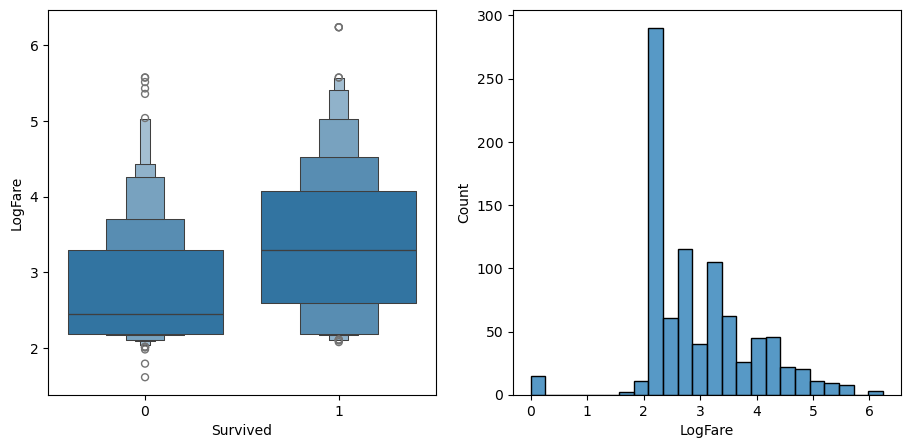

In [14]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.histplot(data=df, x="LogFare", ax=axs[1])
plt.show()

## Decision Trees 101: Gini Impurity

Random forests build on decision trees, so I dig into how they work. Gini impurity measures how mixed a dataset’s classes are: for binary outcomes, it’s 1 - p² - (1-p)², where p is the survival rate. A lower Gini means a purer split. I calculate it for the training set to get a baseline before any splitting happens.

In [15]:
def gini(df, dep='Survived'):
    p = df[dep].mean()
    return 1 - p**2 - (1 - p)**2

In [16]:
gini(trn_df)

0.4694483019820728

## Measuring Splits with Information Gain

Decision trees pick splits that reduce impurity the most, and that’s where information gain comes in. It’s the parent Gini minus the weighted average of the children’s Ginis. I test this with splits like ‘Sex == male’ and ‘LogFare < 2.7’, then build an interactive widget to explore how different features and thresholds affect the gain. It’s a hands-on way to see what drives splits.

In [17]:
def score(df, cond, dep='Survived'):
    parent_gini = gini(df, dep)
    
    lhs = df[cond]
    rhs = df[~cond]
    
    return parent_gini - gini(lhs, dep) * len(lhs)/len(df) - gini(rhs, dep) * len(rhs)/len(df)

In [18]:
score(df, df.Sex=='male') 

0.13964795747285233

In [19]:
score(df, df.LogFare < 2.7)

0.03201654347053301

In [20]:
conds = ['<', '=']

def iscore(nm, split, cnd):
    if cnd == '<':
        return score(trn_df, trn_df[nm] > split)
    else:
        return score(trn_df, trn_df[nm] == split)

from ipywidgets import interact
interact(nm=conts+cats, split=15.5, cnd=conds)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'FamilySize', 'C…

## Finding the Best Splits

To automate split selection, I find the best threshold for ‘Age’ by testing all unique values and picking the one with the highest information gain. Then, I generalize this with `max_in_gain` to check all features. Turns out ‘Sex’ offers the biggest gain—makes sense given the EDA.

In [21]:
nm = "Age"
col = trn_df[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 21.5 , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  ,
       27.  , 28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  ,
       40.  , 40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  ,
       55.  , 55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [22]:
scores = np.array([score(df, df[nm] > threshold) for threshold in unq if not np.isnan(threshold)])
scores = np.nan_to_num(scores, nan=0.0)
unq[scores.argmax()]

6.0

In [23]:
def max_in_gain(df, nm):
    col = df[nm]
    unq = col.dropna().unique()
    scores = np.array([score(df, df[nm] <= o) for o in unq if not np.isnan(o)])
    scores = np.nan_to_num(scores, nan=0.0)
    idx = scores.argmax()
    return unq[idx],scores[idx]

max_in_gain(df, "Age")

(6.0, 0.01128312550541316)

In [24]:
cols = cats+conts
{o:max_in_gain(trn_df, o) for o in cols}

{'Sex': (0, 0.13777997649438187),
 'Embarked': (0, 0.011962629260368396),
 'Title': (12, 0.05835211917297576),
 'Pclass': (1, 0.04633689581360795),
 'IsAlone': (0, 0.01530191370299705),
 'Age': (5.0, 0.011566117051788616),
 'SibSp': (3, 0.0059358222809473525),
 'Parch': (0, 0.009205311139441064),
 'LogFare': (2.4390808375825834, 0.03861217211191381),
 'FamilySize': (1, 0.01530191370299705),
 'CabinKnown': (0, 0.04235486147096447)}

## Trying Cross-Entropy

Since ‘Sex’ topped the Gini charts, I’m curious if another impurity measure agrees. Cross-entropy (aka log loss) is -p*log(p) - (1-p)*log(1-p), with a tweak to handle pure nodes (p=0 or 1). I redefine the scoring functions with cross-entropy and re-run the best-split search. Spoiler: ‘Sex’ still rules.

In [25]:
def cross_entropy(df, dep='Survived'):
    p = df[dep].mean()
    if p == 0 or p == 1:
        return 0  # to avoid log(0) issues; entropy is 0 when pure
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

In [26]:
def ce_score(df, cond, dep='Survived'):
    parent_ce = cross_entropy(df, dep)
    
    lhs = df[cond]
    rhs = df[~cond]
    
    return parent_ce - cross_entropy(lhs, dep) * len(lhs)/len(df) - cross_entropy(rhs, dep) * len(rhs)/len(df)

In [27]:
def max_in_gain_ce(df, nm):
    col = df[nm]
    unq = col.dropna().unique()
    scores = np.array([ce_score(df, df[nm] <= o) for o in unq if not np.isnan(o)])
    scores = np.nan_to_num(scores, nan=0.0)
    idx = scores.argmax()
    return unq[idx],scores[idx]

max_in_gain_ce(df, "Age")

(6.0, 0.011578722768531668)

In [28]:
cols = cats+conts
{o:max_in_gain_ce(trn_df, o) for o in cols}

{'Sex': (0, 0.1492870700344417),
 'Embarked': (0, 0.01238250808610497),
 'Title': (12, 0.06141118175627637),
 'Pclass': (1, 0.04978432383360609),
 'IsAlone': (0, 0.01621211811964257),
 'Age': (5.0, 0.011881651194982856),
 'SibSp': (4, 0.008046329770353022),
 'Parch': (0, 0.009610333976850266),
 'LogFare': (2.4390808375825834, 0.043145685874994955),
 'FamilySize': (1, 0.01621211811964257),
 'CabinKnown': (0, 0.04401681021051718)}

## Digging Deeper: Subgroup Splits

Since ‘Sex’ is so dominant, I split the data into males and females and find the best splits within each group, using both Gini and cross-entropy. It’s like watching a decision tree branch out—after ‘Sex’, other features get their chance to shine.

In [29]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [30]:
{o:max_in_gain_ce(males, o) for o in cols}

{'Embarked': (0, 0.007312842174070966),
 'Title': (8, 0.02805975622713569),
 'Pclass': (0, 0.01820000312353115),
 'IsAlone': (0, 0.006781257875705715),
 'Age': (6.0, 0.02955359013495068),
 'SibSp': (2, 0.004308924141516346),
 'Parch': (0, 0.007092979810789185),
 'LogFare': (3.305053521109253, 0.01888673922233519),
 'FamilySize': (1, 0.006781257875705715),
 'CabinKnown': (0, 0.031229581076443677)}

In [31]:
{o:max_in_gain(males, o) for o in cols}

{'Embarked': (0, 0.004906974135611308),
 'Title': (8, 0.021467785077321527),
 'Pclass': (0, 0.012382352046451606),
 'IsAlone': (0, 0.004297912282940547),
 'Age': (6.0, 0.024278381799043514),
 'SibSp': (0, 0.0025127696155566315),
 'Parch': (0, 0.0047276466150457525),
 'LogFare': (3.305053521109253, 0.01236734578559559),
 'FamilySize': (1, 0.004297912282940533),
 'CabinKnown': (0, 0.021985396693622122)}

In [32]:
{o:max_in_gain_ce(females, o) for o in cols}

{'Embarked': (0, 0.016872459262018524),
 'Title': (9, 0.01911434463924072),
 'Pclass': (1, 0.16263640353015985),
 'IsAlone': (0, 0.003886258872752707),
 'Age': (21.5, 0.028495758626381373),
 'SibSp': (2, 0.0333962543573451),
 'Parch': (3, 0.028004538109382193),
 'LogFare': (3.8691155044168695, 0.042930677976993736),
 'FamilySize': (4, 0.06375610199748942),
 'CabinKnown': (0, 0.04849974935777902)}

In [33]:
{o:max_in_gain(females, o) for o in cols}

{'Embarked': (0, 0.011461160480329968),
 'Title': (9, 0.01413296184061237),
 'Pclass': (1, 0.11219188214498144),
 'IsAlone': (0, 0.0029583267587040274),
 'Age': (21.5, 0.02233304619406634),
 'SibSp': (2, 0.03008342083827442),
 'Parch': (3, 0.022741218936554175),
 'LogFare': (3.8691155044168695, 0.02793763742489827),
 'FamilySize': (4, 0.05695658296187893),
 'CabinKnown': (0, 0.03153037142456433)}

## Building Decision Trees

Now, I put theory into practice with scikit-learn’s `DecisionTreeClassifier`. I start with a small tree (max 4 leaf nodes) to keep it simple and visualizable, then plot it with graphviz. Later, I train a larger tree with `min_samples_leaf=25` to balance complexity and overfitting, checking MAE each time to see how performance shifts.

In [34]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [35]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

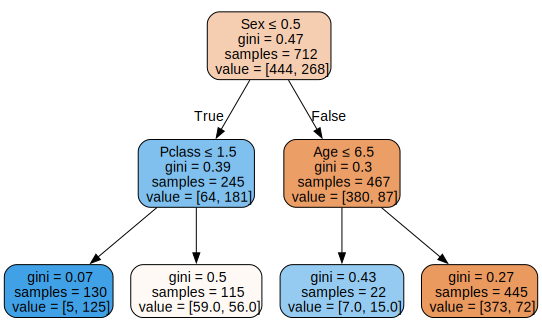

In [36]:
draw_tree(m, trn_xs, size=10)

In [37]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2346368715083799

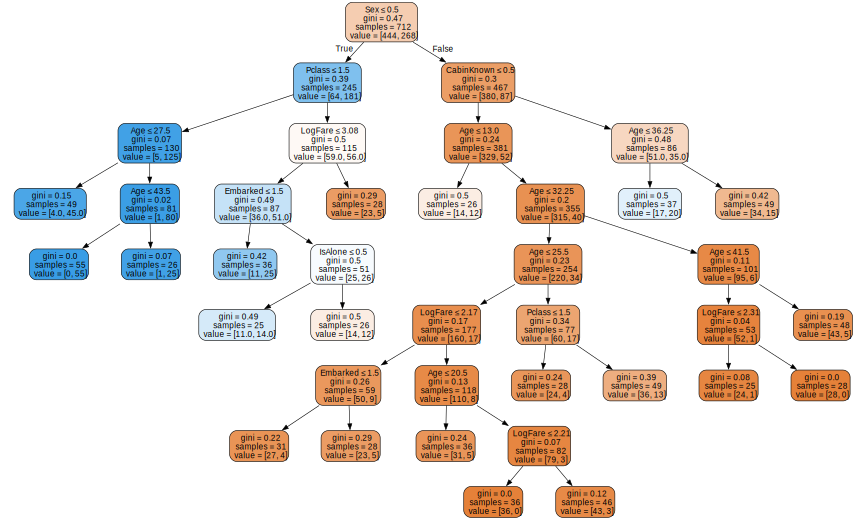

In [38]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [39]:
mean_absolute_error(val_y, m.predict(val_xs))


0.18435754189944134

## Testing the Tree

I preprocess the test set, make predictions with the larger tree, and save them to a CSV. It’s a first stab at the competition submission, but I know random forests can do better.

In [40]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

## Crafting a Random Forest from Scratch

To really get random forests, I build one manually: 25 trees, each trained on a random 80% of the data. Averaging their predictions reduces variance compared to a single tree -> ensemble magic! Well, magic: This random sampling, known as bagging, ensures each tree learns slightly different patterns, reducing overfitting. By averaging their predictions, the ensemble combines these diverse perspectives, lowering variance compared to a single tree. The key is that the trees’ errors are less correlated, so averaging emphasizes the true signal while reducing noise. I check the MAE to see the improvement.

In [42]:
def get_tree(prop=0.80):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=10).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [43]:
trees = [get_tree() for t in range(25)]

In [44]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.21810055865921787

## The Real Deal: Scikit-Learn’s Random Forest

For efficiency, I switch to scikit-learn’s `RandomForestClassifier` with 25 trees and a tighter `min_samples_leaf`. It handles randomness and feature selection automatically, often outperforming my manual version. I test it on the validation set and submit predictions.

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(25, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.1787709497206704

In [46]:
subm(rf.predict(tst_xs), 'rf')

## What Matters Most?

Finally, I plot feature importances from the random forest. It’s a neat way to see which features drive predictions—‘Sex’ likely tops the list, but others like ‘Title’ or ‘LogFare’ might surprise me. This insight is gold for understanding the model and the data.

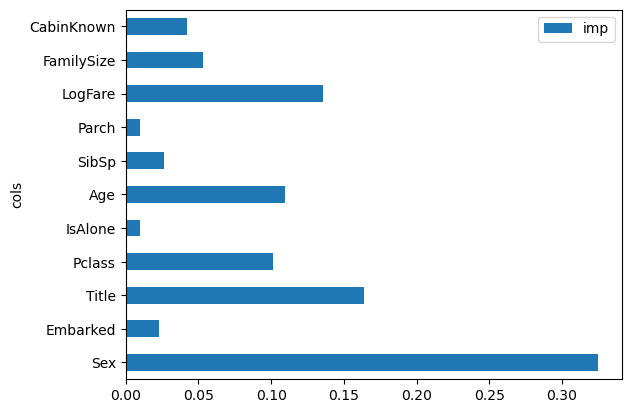

In [47]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');